<a href="https://colab.research.google.com/github/DiabeticRetinopathy114/114_DR/blob/main/ResNet_50_stage1_bir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

aptos2019_blindness_detection_path = kagglehub.competition_download('aptos2019-blindness-detection')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aptos2019-blindness-detection/sample_submission.csv
/kaggle/input/aptos2019-blindness-detection/train.csv
/kaggle/input/aptos2019-blindness-detection/test.csv
/kaggle/input/aptos2019-blindness-detection/train_images/ef476be214d4.png
/kaggle/input/aptos2019-blindness-detection/train_images/6dcde47060f9.png
/kaggle/input/aptos2019-blindness-detection/train_images/ec363f48867b.png
/kaggle/input/aptos2019-blindness-detection/train_images/17f6c7072f61.png
/kaggle/input/aptos2019-blindness-detection/train_images/b49b2fac2514.png
/kaggle/input/aptos2019-blindness-detection/train_images/af6166d57f13.png
/kaggle/input/aptos2019-blindness-detection/train_images/8d13c46e7d75.png
/kaggle/input/aptos2019-blindness-detection/train_images/c3b15bf9b4bc.png
/kaggle/input/aptos2019-blindness-detection/train_images/be68322c7223.png
/kaggle/input/aptos2019-blindness-detection/train_images/88e4399d207c.png
/kaggle/input/aptos2019-blindness-detection/train_images/0243404e8a00.png
/kaggle/input

In [ ]:
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
from tensorflow.keras import optimizers, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score, recall_score
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2

2025-04-26 13:18:17.265539: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745673497.480246      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745673497.540350      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
from tensorflow.keras import backend as K


In [ ]:
import logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 只顯示 ERROR
logging.getLogger('tensorflow').setLevel(logging.ERROR)

In [ ]:
def seed_everything(seed=2019):
    random.seed(seed)                        # Python標準隨機
    os.environ['PYTHONHASHSEED'] = str(seed)  # Python內建hash隨機
    np.random.seed(seed)                     # NumPy隨機
    tf.random.set_seed(seed)                 # TensorFlow隨機

seed_everything()

In [ ]:
# 讀取資料
train_df = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test_df = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
train_df['id_code'] = train_df['id_code'].apply(lambda x: x + '.png')
test_df["id_code"] = test_df["id_code"].apply(lambda x: x + ".png")

# Stage 1: 0 vs (1-4)
train_df_stage1 = train_df.copy()
train_df_stage1['diagnosis'] = train_df_stage1['diagnosis'].apply(lambda x: 0 if x == 0 else 1)
train_df_stage1['diagnosis'] = train_df_stage1['diagnosis'].astype(str)

# Stage 2: 正確做法：
# 只拿 diagnosis = 1,2,3,4 的病患（完全排除診斷0的人）
train_df_stage2 = train_df[train_df['diagnosis'] != 0].copy()

# 診斷值減1（把原本1->0, 2->1, 3->2, 4->3）
train_df_stage2['diagnosis'] = train_df_stage2['diagnosis'].astype(int) - 1
train_df_stage2['diagnosis'] = train_df_stage2['diagnosis'].astype(str)

# ✅ 確認一下，應該只剩下 0,1,2,3 類別
print(train_df_stage2['diagnosis'].value_counts())


diagnosis
1    999
0    370
3    295
2    193
Name: count, dtype: int64


In [ ]:
print(train_df['diagnosis'].value_counts())


diagnosis
0    1805
2     999
1     370
4     295
3     193
Name: count, dtype: int64


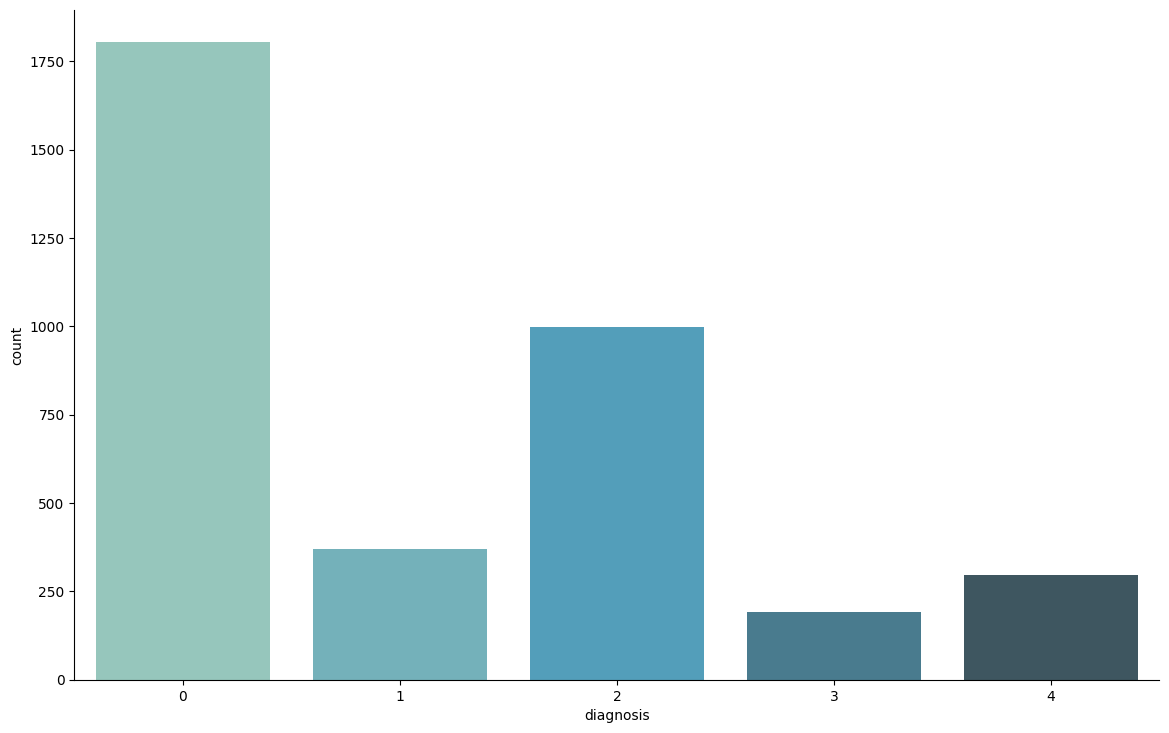

In [ ]:
f, ax = plt.subplots(figsize=(14, 8.7))
ax = sns.countplot(x="diagnosis", data=train_df, palette="GnBu_d")
sns.despine()
plt.show()

In [ ]:
def preprocess_eyeimage(img):
    """
    預處理眼底圖像：應用CLAHE增強對比度
    假設輸入已經被縮放到[0,1]範圍
    """
    # 將[0,1]範圍轉換為[0,255]以便處理
    img = (img * 255).astype(np.uint8)

    if len(img.shape) == 3 and img.shape[2] == 3:
        # 將RGB轉為HSV，只處理V通道
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        h, s, v = cv2.split(hsv)

        # 應用CLAHE到V通道
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        v = clahe.apply(v)

        # 合併通道
        hsv = cv2.merge([h, s, v])
        enhanced = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

        # 轉回[0,1]範圍
        return enhanced / 255.0
    else:
        # 直接處理灰度圖
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        enhanced = clahe.apply(img)
        return enhanced / 255.0

In [ ]:
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_eyeimage
)

In [ ]:
train_datagen = ImageDataGenerator(
    validation_split=0.2,
  #  rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode="nearest",
    preprocessing_function=preprocess_eyeimage #
)

train_generator_stage1 = train_datagen.flow_from_dataframe(
    train_df_stage1,
    directory="../input/aptos2019-blindness-detection/train_images/",
    x_col='id_code',
    y_col='diagnosis',
    subset='training',
    batch_size=32,
    shuffle=True,
    class_mode='binary',
    target_size=(224,224),
    seed=2019
)

valid_generator_stage1 = train_datagen.flow_from_dataframe(
    train_df_stage1,
    directory="../input/aptos2019-blindness-detection/train_images/",
    x_col='id_code',
    y_col='diagnosis',
    subset='validation',
    batch_size=32,
    shuffle=False,
    class_mode='binary',
    target_size=(224,224),
    seed=2019
)

test_generator_stage1 = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory="../input/aptos2019-blindness-detection/test_images/",
    x_col='id_code',
    y_col='diagnosis',
    batch_size=1,
    shuffle=False,
    class_mode=None,
    target_size=(224,224),
    seed=2019
)


Found 2930 validated image filenames belonging to 2 classes.
Found 732 validated image filenames belonging to 2 classes.
Found 1928 validated image filenames.


In [ ]:
train_generator_stage2 = train_datagen.flow_from_dataframe(
    train_df_stage2,
    directory="../input/aptos2019-blindness-detection/train_images/",
    x_col='id_code',
    y_col='diagnosis',
    subset='training',
    batch_size=16,
    shuffle=True,
    class_mode='categorical',
    target_size=(224,224),
    seed=2019
)

valid_generator_stage2 = train_datagen.flow_from_dataframe(
    train_df_stage2,
    directory="../input/aptos2019-blindness-detection/train_images/",
    x_col='id_code',
    y_col='diagnosis',
    subset='validation',
    batch_size=16,
    shuffle=False,
    class_mode='categorical',
    target_size=(224,224),
    seed=2019
)
test_generator_stage2 = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory="../input/aptos2019-blindness-detection/test_images/",
    x_col="id_code",
    batch_size=1,
    class_mode=None,
    shuffle=False,
    target_size=(224, 224),  # or (HEIGHT, WIDTH)
    seed=2019
)


Found 1486 validated image filenames belonging to 4 classes.
Found 371 validated image filenames belonging to 4 classes.
Found 1928 validated image filenames.


In [ ]:
# 拆出一部分當test集 (比如20%)
#from sklearn.model_selection import train_test_split

#train_df_stage1_train, train_df_stage1_test = train_test_split(
#    train_df_stage1,
#    test_size=0.2,
#    stratify=train_df_stage1['diagnosis'],
#    random_state=42
#)

# 接著建 test_generator
#test_datagen = ImageDataGenerator(rescale=1./255)
 #




In [ ]:
def create_resnet_model(output_classes, input_shape=(224, 224, 3), freeze_base=True):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    if freeze_base:
        base_model.trainable = False    # 凍結ResNet主幹
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    output = Dense(output_classes, activation='softmax' if output_classes > 1 else 'sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model


In [ ]:
# 建立 Stage 1 的模型
model_stage1 = create_resnet_model(output_classes=1, freeze_base=True)
callbacks_stage1 = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    #ModelCheckpoint('best_model_stage1.h5', monitor='val_loss', save_best_only=True)
]

def binary_focal_loss(gamma=2.0, alpha=0.25):
    def loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1. - 1e-7)  # 防止 log(0)

        # 計算 focal loss
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        focal_weight = alpha * tf.pow(1 - pt, gamma)
        loss = -focal_weight * tf.math.log(pt)

        return tf.reduce_mean(loss)  # ✅ 取平均，讓loss數值合理
    return loss_fn


model_stage1.compile(
    optimizer=Adam(learning_rate=5e-5),
    loss=binary_focal_loss(gamma=2.0, alpha=0.25),
    metrics=['accuracy']
)

# 顯示模型結構
model_stage1.summary()


I0000 00:00:1745673562.089821      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745673562.090548      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,771,457 (94.50 MB)

 Trainable params: 1,182,209 (4.51 MB)

 Non-trainable params: 23,589,248 (89.99 MB)

In [ ]:
labels = train_generator_stage1.labels
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weight_dict = dict(enumerate(class_weights))
history_stage1 = model_stage1.fit(
    train_generator_stage1,
    validation_data=valid_generator_stage1,
    callbacks=callbacks_stage1,
    epochs=10,
    class_weight=class_weight_dict
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745673648.352411     102 service.cc:148] XLA service 0x7fe51000e560 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745673648.353629     102 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745673648.353650     102 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745673649.891409     102 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1:12:57 48s/step - accuracy: 0.3438 - loss: 0.3897

I0000 00:00:1745673656.141326     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


92/92 ━━━━━━━━━━━━━━━━━━━━ 476s 5s/step - accuracy: 0.5995 - loss: 0.2307 - val_accuracy: 0.7117 - val_loss: 0.1395 - learning_rate: 5.0000e-05
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 379s 4s/step - accuracy: 0.7366 - loss: 0.1651 - val_accuracy: 0.5792 - val_loss: 0.1266 - learning_rate: 5.0000e-05
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 380s 4s/step - accuracy: 0.7601 - loss: 0.1381 - val_accuracy: 0.4850 - val_loss: 0.1181 - learning_rate: 5.0000e-05
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 379s 4s/step - accuracy: 0.7701 - loss: 0.1321 - val_accuracy: 0.7404 - val_loss: 0.1008 - learning_rate: 5.0000e-05
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 379s 4s/step - accuracy: 0.7855 - loss: 0.1209 - val_accuracy: 0.8429 - val_loss: 0.0861 - learning_rate: 5.0000e-05
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 378s 4s/step - accuracy: 0.7972 - loss: 0.1093 - val_accuracy: 0.6981 - val_loss: 0.0951 - learning_rate: 5.0000e-05
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 380s 4s/step - accuracy: 0.8033 - loss: 0.1

23/23 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step
Stage 1 Confusion Matrix
 [[253  84]
 [ 16 379]]


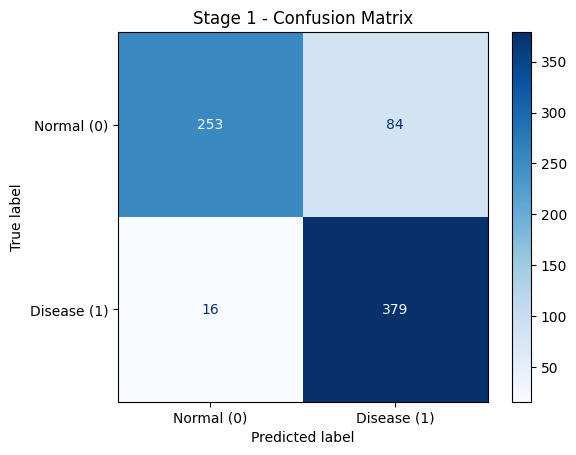

Stage 1 Recall: 0.9595
Stage 1 Kappa Score: 0.7209


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Stage 1
y_true_stage1 = valid_generator_stage1.labels
y_pred_stage1 = (model_stage1.predict(valid_generator_stage1) > 0.5).astype(int)

cm1 = confusion_matrix(y_true_stage1, y_pred_stage1)
print('Stage 1 Confusion Matrix\n', cm1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=['Normal (0)', 'Disease (1)'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Stage 1 - Confusion Matrix')
plt.show()

recall1 = recall_score(y_true_stage1, y_pred_stage1)
print(f'Stage 1 Recall: {recall1:.4f}')

kappa1 = cohen_kappa_score(y_true_stage1, y_pred_stage1)
print(f'Stage 1 Kappa Score: {kappa1:.4f}')

In [ ]:
loss, acc = model_stage1.evaluate(valid_generator_stage1, verbose=1)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {acc:.4f}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.8811 - loss: 0.0645
Validation Loss: 0.0670
Validation Accuracy: 0.8675


In [ ]:
def plot_training(history, stage):
    fig, ax = plt.subplots(1, 2, figsize=(16,5))

    # Accuracy曲線
    ax[0].plot(history.history['accuracy'], label='train_acc')
    ax[0].plot(history.history['val_accuracy'], label='val_acc')
    ax[0].set_title(f'{stage} - Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    # Loss曲線
    ax[1].plot(history.history['loss'], label='train_loss')
    ax[1].plot(history.history['val_loss'], label='val_loss')
    ax[1].set_title(f'{stage} - Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    plt.show()

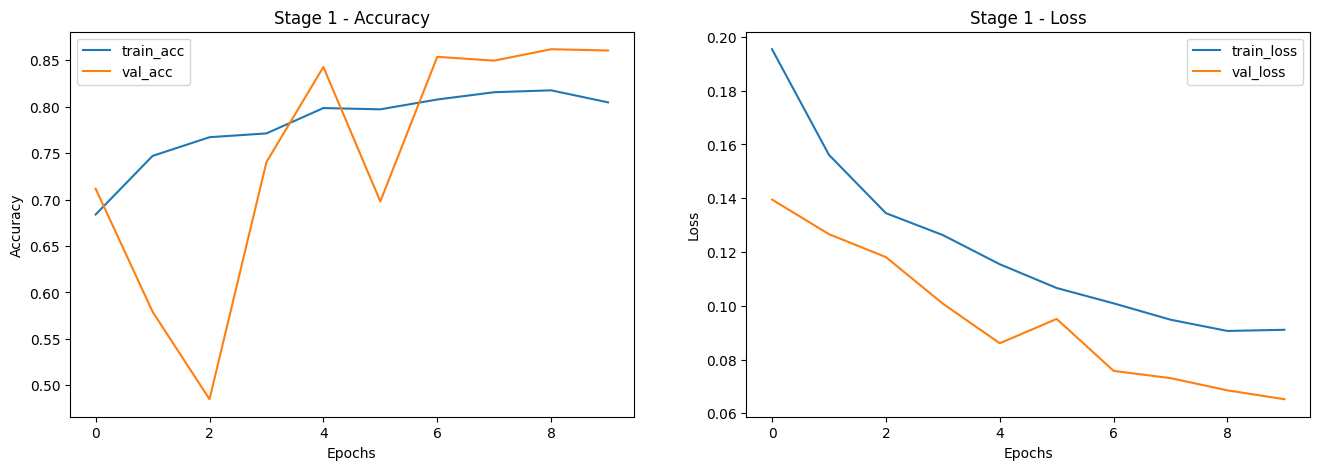

In [ ]:
plot_training(history_stage1, 'Stage 1')

# stage2

In [ ]:
# 建立 Stage 2 的模型
model_stage2 = create_resnet_model(output_classes=4)
# 解凍ResNet後半段
model_stage2.set_weights(model_stage1.get_weights())
# 🔵解凍ResNet後30層Fine-tune
for layer in model_stage2.layers[-30:]:
    layer.trainable = True
def categorical_focal_loss(gamma=2., alpha=0.25):
    def loss_fn(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-8, 1-1e-8)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.math.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))
    return loss_fn
callbacks_stage2 = [
    EarlyStopping(monitor='val_loss', patience=10,verbose=1, restore_best_weights=True),
    #ModelCheckpoint('best_model_stage2.h5', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

labels_stage2 = train_generator_stage2.labels
class_weights_stage2 = class_weight.compute_class_weight('balanced', classes=np.unique(labels_stage2), y=labels_stage2)
class_weight_dict_stage2 = dict(enumerate(class_weights_stage2))
# 編譯模型
model_stage2.compile(
    optimizer=Adam(learning_rate=5e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

# 顯示模型結構
model_stage2.summary()


In [ ]:

history_stage2 = model_stage2.fit(
    train_generator_stage2,
    validation_data=valid_generator_stage2,
    callbacks=callbacks_stage2,
    class_weight=class_weight_dict_stage2,
    epochs=20
)


In [ ]:
def plot_training(history, stage):
    plt.figure(figsize=(12,4))
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.title(f'{stage} - Accuracy')
    plt.legend()
    plt.show()


In [ ]:
plot_training(history_stage1, 'Stage 1')
plot_training(history_stage2, 'Stage 2')


In [ ]:
# Stage 1
y_true_stage1 = valid_generator_stage1.labels
y_pred_stage1 = (model_stage1.predict(valid_generator_stage1) > 0.5).astype(int)

cm1 = confusion_matrix(y_true_stage1, y_pred_stage1)
print('Stage 1 Confusion Matrix\n', cm1)

recall1 = recall_score(y_true_stage1, y_pred_stage1)
print(f'Stage 1 Recall: {recall1:.4f}')

kappa1 = cohen_kappa_score(y_true_stage1, y_pred_stage1)
print(f'Stage 1 Kappa Score: {kappa1:.4f}')

# Stage 2
y_true_stage2 = valid_generator_stage2.labels.argmax(axis=1)
y_pred_stage2 = model_stage2.predict(valid_generator_stage2).argmax(axis=1)

cm2 = confusion_matrix(y_true_stage2, y_pred_stage2)
print('Stage 2 Confusion Matrix\n', cm2)

recall2 = recall_score(y_true_stage2, y_pred_stage2, average='macro')
print(f'Stage 2 Macro Recall: {recall2:.4f}')

kappa2 = cohen_kappa_score(y_true_stage2, y_pred_stage2)
print(f'Stage 2 Kappa Score: {kappa2:.4f}')


In [ ]:
# 預測（模型輸出 sigmoid 機率）
pred_stage1_prob = model_stage1.predict(test_generator_stage1, verbose=1)

# 二分類結果（閾值為 0.5）
pred_stage1_label = (pred_stage1_prob > 0.5).astype(int).flatten()

# 存成 submission
submission_stage1 = pd.DataFrame({
    "id_code": test_df["id_code"].str.replace(".png", "", regex=False),
    "diagnosis": pred_stage1_label
})
submission_stage1.to_csv("submission_stage1.csv", index=False)


In [ ]:
# 預測（模型輸出 softmax）
pred_stage2_prob = model_stage2.predict(test_generator_stage2, verbose=1)

# 多分類結果（取最大機率 index）
pred_stage2_label = pred_stage2_prob.argmax(axis=1)

# 還原成原始 diagnosis（1~4）
final_stage2_diagnosis = pred_stage2_label + 1

# 存成 submission
submission_stage2 = pd.DataFrame({
    "id_code": test_df["id_code"].str.replace(".png", "", regex=False),
    "diagnosis": final_stage2_diagnosis
})
submission_stage2.to_csv("submission_stage2.csv", index=False)